# FASTER R-CNN

In [1]:
# imports
import numpy as np
import tensorflow as tf

In [2]:
#Feature Extraction
# create random image
image = np.zeros((1,3,800,800))
#change type to float
image = image.astype(np.float32)
# convert to tensor
image = tf.convert_to_tensor(image)

In [3]:
# Using just tensorflow to create generic data of ...
# image
image = tf.zeros([1,800,800,3], tf.float32)
# bbox
bbox = tf.constant([[20, 30, 400, 500], [300, 400, 500, 600]])
# labels for each bbox
labels = tf.constant([6,8]) 
sub_sample = 16

The VGG16 network is used as a feature extraction module here, This acts as a backbone for both the RPN network and Fast_R-CNN network. We need to make a few changes to the VGG network inorder to make this work. Since the input of the network is 800, the output of the feature extraction module should have a feature map size of (800//16). So we need to check where the VGG16 module is achieving this feature map size and trim the network till der. This can be done in the following way.

#### Pytorch implementation:
https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439

## 1 ) VGG16  import

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers
from tensorflow.keras import initializers

In [5]:
# The default input size for this model is 224x224.
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=[800, 800, 3]))

In [6]:
vgg.trainable = False

In [7]:
#Show the layers
vgg.layers
# or uncomment the next line
#vgg.summary()

In [8]:
#how to pass a input test tensor through the layers without compile the model?
im = image
fe_layers = vgg.layers
l_c = 0
req_layers = []
print("size of vgg feature layers: ", len(fe_layers))
# Use CPU to test the convolutions
with tf.device('CPU:0'):
    for i in fe_layers:
        im = i(im)
        if im.shape[1] < 800//16:
            print('brake')
            break
        req_layers.append(i)
        l_c += 1
        out_channels = im.shape
print('shape of ouput: ', out_channels)
print('number of layers needed: ', l_c)

size of vgg feature layers:  19
brake
shape of ouput:  (1, 50, 50, 512)
number of layers needed:  18


In [9]:
# print the required layers
print(req_layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F394C81D88>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F394C8FF08>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F394C9BC08>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F394CABB08>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F3DCE0B448>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F3DCE21C48>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F3DCE26FC8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F3DCE36D48>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F3DCE12B88>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F3DCE3E808>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F3DCE4C048>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F3

In [10]:
# create the bakcbone for fast r-cnn
input_fe = layers.Input(shape=[800, 800, 3])
fe_extractor = req_layers[1](input_fe)
for l in range(2,len(req_layers)):
    fe_extractor = req_layers[l](fe_extractor)

In [11]:
# Test feature extractor model output
fe_model = Model(inputs=input_fe, outputs=fe_extractor)
out_map = image
with tf.device('CPU:0'):
    out_map = fe_model(out_map)
print("shape of output: ",out_map.shape)
del(fe_model)

# Input = input_fe,
# Output of extractor feature = fe_extractor

shape of output:  (1, 50, 50, 512)


## 2) Anchor boxes

In [12]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using matplotlib backend: Qt5Agg


We will use anchor_scales of 8, 16, 32, ratio of 0.5, 1, 2 and sub sampling of 16 (Since we have pooled our image from 800 px to 50px). Now every pixel in the output feature map maps to corresponding 16 * 16 pixels in the image.

At each pixel location on the feature map, We need to generate 9 anchor boxes (number of anchor_scales and number of ratios) and each anchor box will have ‘y1’, ‘x1’, ‘y2’, ‘x2’. So at each location anchor will have a shape of (9, 4). 

In [13]:
# As an example will be created 9 anchor boxes space for 'y1', 'x1', 'y2', 'x2'
ratios = [0.5, 1, 2]
# 0.5 : ratio 2:1; 1 : ratio 1:1; 2 : ratio 1:2;
anchor_scales = [8, 16, 32]
anchor_base = np.zeros((len(ratios)*len(anchor_scales), 4), dtype=np.float32)

print(anchor_base)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [14]:
# example to fill the anchor x and y coordinates values for the 9 anchor boxes of the respective size and ratio
sub_sample = 16
ctr_y = sub_sample / 2.
ctr_x = sub_sample / 2.

print('center of the sample anchor boxes: yc = {}, xc = {}'.format(ctr_y, ctr_x))
for i in range(len(ratios)):
    for j in range(len(anchor_scales)):
        h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
        w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
        #print("height: {}, width: {}".format(h, w))
        
        index = i * len(anchor_scales) + j
        
        anchor_base[index, 0] = ctr_y - h/ 2.
        anchor_base[index, 1] = ctr_x - w/ 2.
        anchor_base[index, 2] = ctr_y + h/ 2.
        anchor_base[index, 3] = ctr_x + w/ 2.

print(anchor_base)

center of the sample anchor boxes: yc = 8.0, xc = 8.0
[[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]
 [-173.01933  -354.03867   189.01933   370.03867 ]
 [ -56.        -56.         72.         72.      ]
 [-120.       -120.        136.        136.      ]
 [-248.       -248.        264.        264.      ]
 [ -82.50967   -37.254833   98.50967    53.254833]
 [-173.01933   -82.50967   189.01933    98.50967 ]
 [-354.03867  -173.01933   370.03867   189.01933 ]]


These are the anchor locations at the first feature map pixel, we have to now generate these anchors at all the locations of feature map. 

In the later section we will label them with -1 and remove them when calculating the loss the functions and generating proposals for anchor boxes.

Also Since we got 9 anchors at each location and there 50 * 50 such locations inside an image, We will get 17500 ((50 * 50 * 9) - (number of invalid anchor boxes)) anchors in total.

### Generate anchors for all the feature map (50 x 50 x 512) 

In [15]:
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)

ctr_x

array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
       224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416,
       432, 448, 464, 480, 496, 512, 528, 544, 560, 576, 592, 608, 624,
       640, 656, 672, 688, 704, 720, 736, 752, 768, 784, 800])

In [16]:
# Generate the center coordinates for every anchor box
index = 0
ctr = []
#print(ctr[0][1])
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        #print(index)
        ctr.append([ctr_y[y] - 8 , ctr_x[x] - 8])
        index += 1
ctr = np.array(ctr)

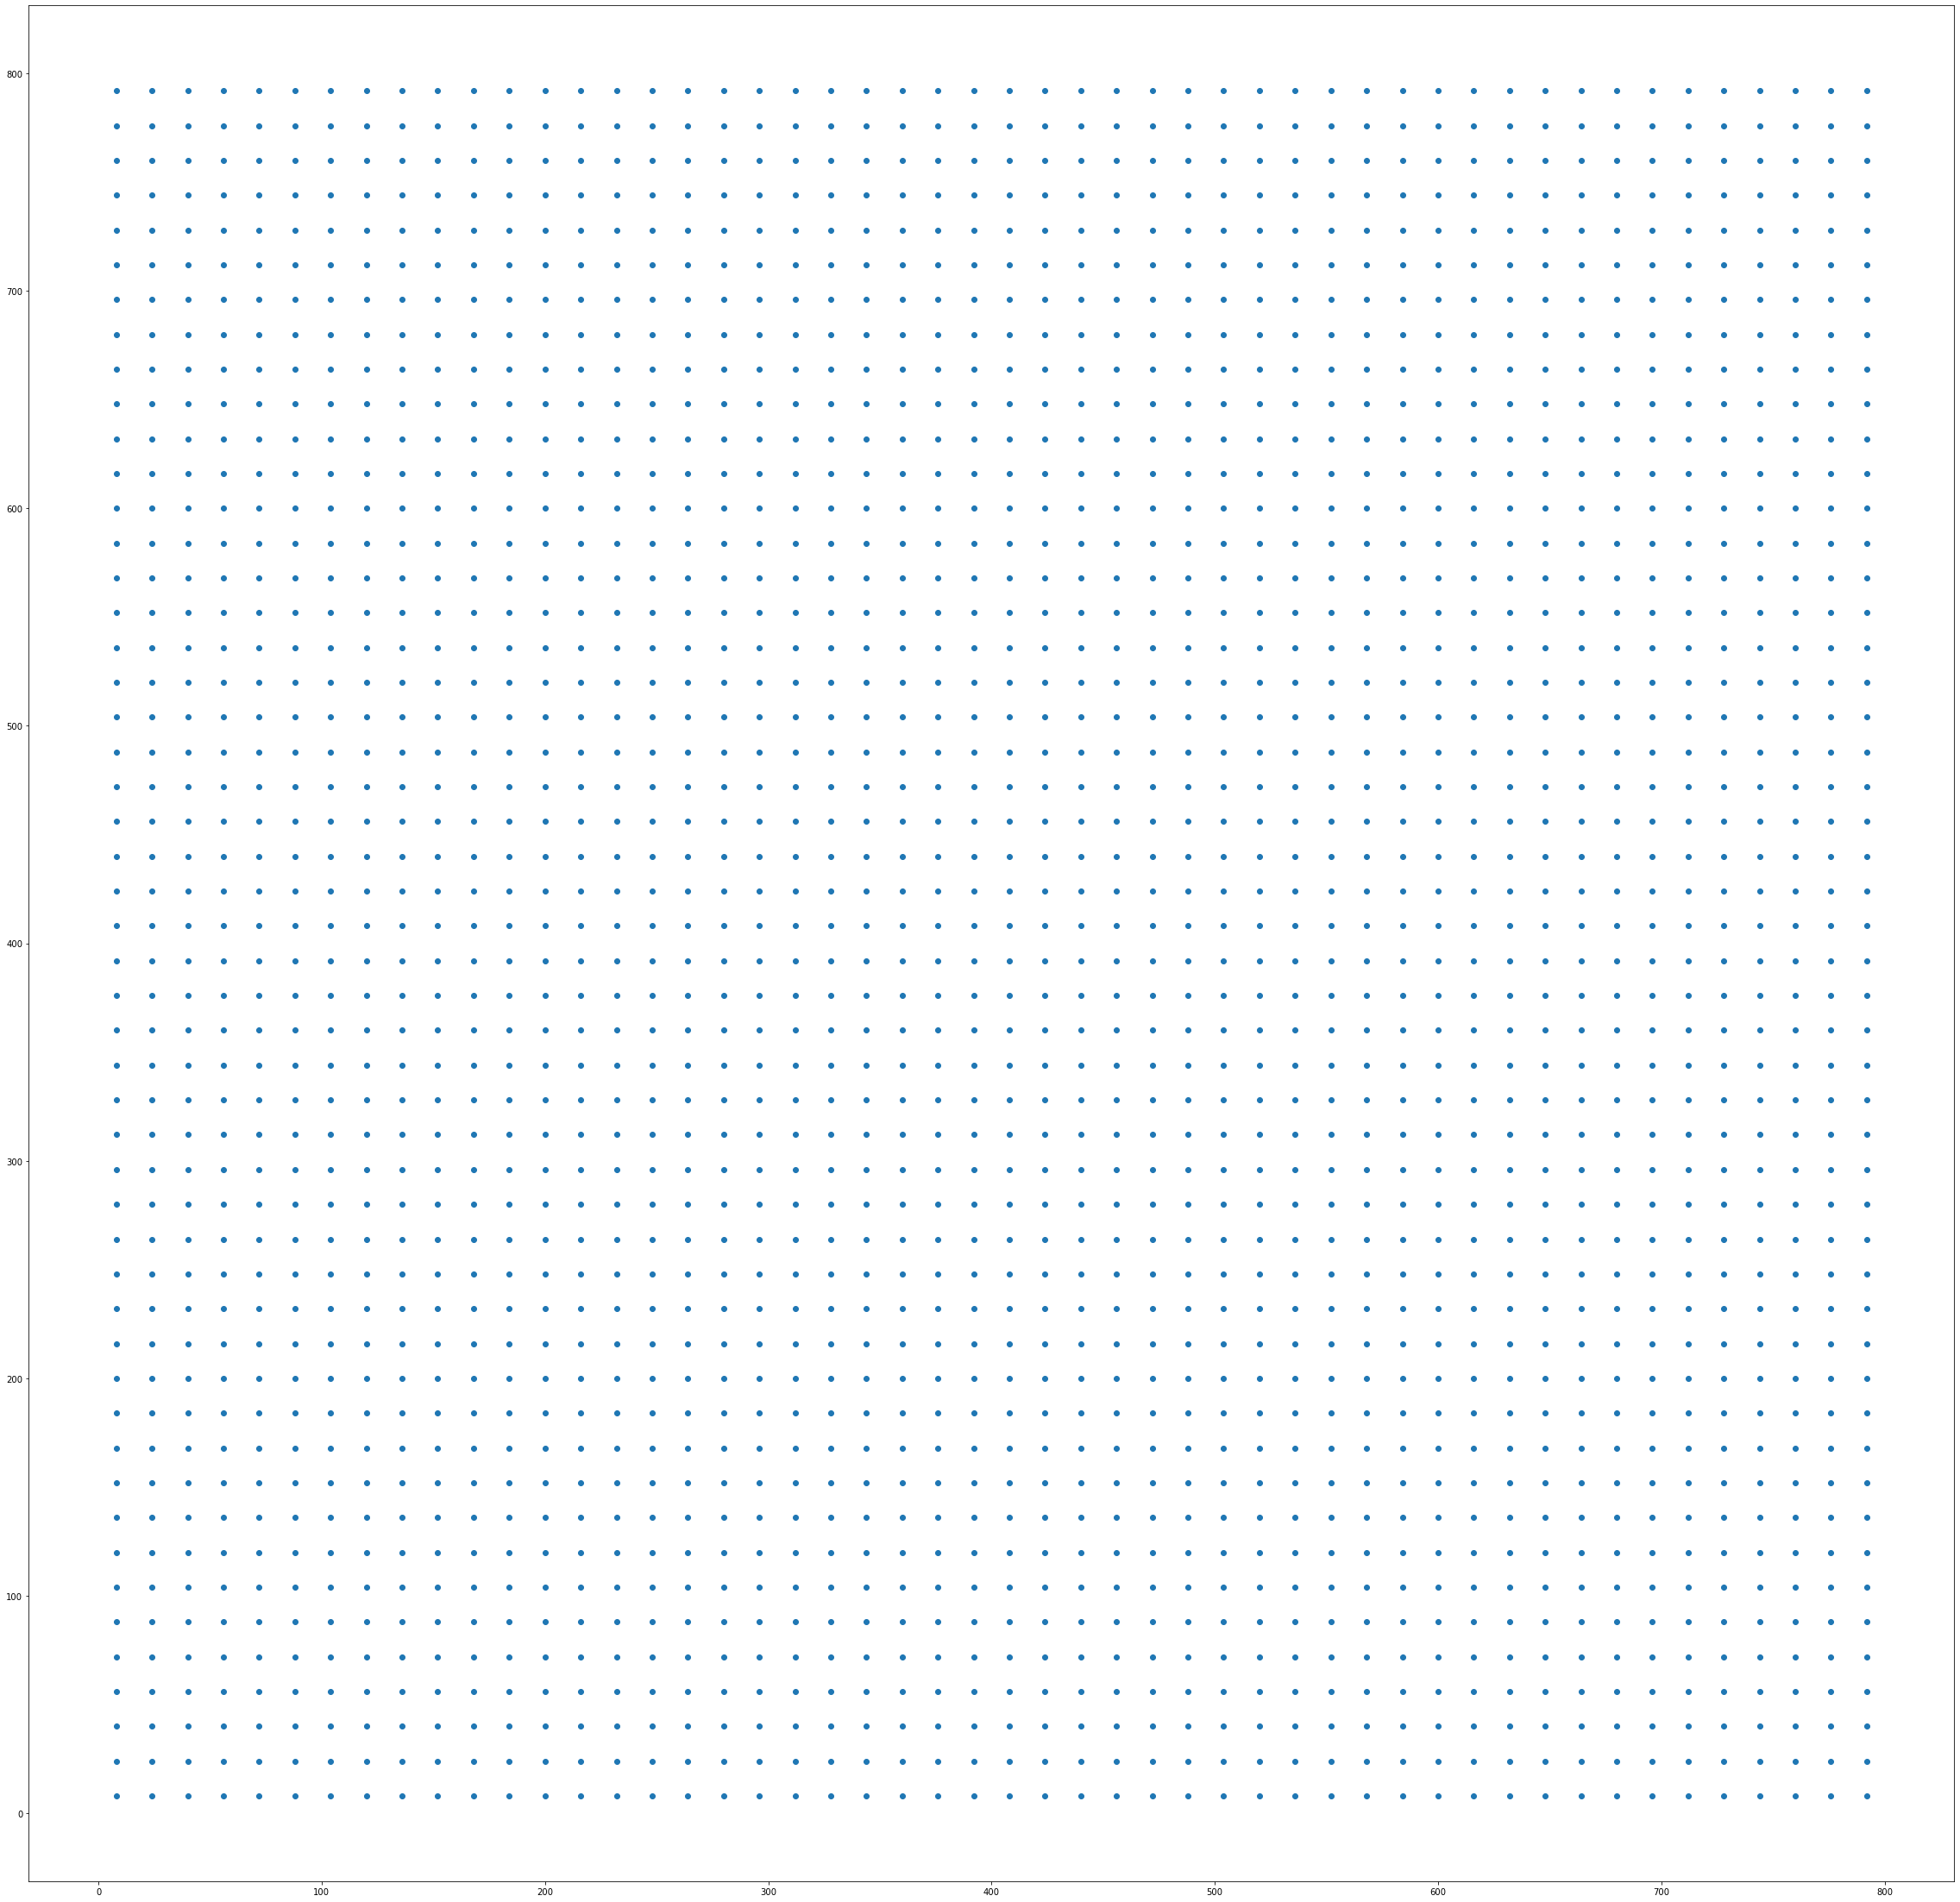

In [17]:
# Plot the center of the anchor boxes
plt.figure(figsize=(40,40))
plt.scatter(ctr[:,1],ctr[:,0])
plt.show()

The output will be the (x, y) value at each location as shown in the image above. Together we have 2500 anchor centers. Now at each center we need to generate the anchor boxes. This can be done using the code we have used for generating anchor at one location, adding an extract for loop for supplying centers of each anchor will do. Lets see how this is done


In [18]:
# Create the 9 anchor box for every center
anchors = np.zeros(((fe_size*fe_size*9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
            w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
            
            anchors[index, 0] = ctr_y - h/ 2.
            anchors[index, 1] = ctr_x - w/ 2.
            anchors[index, 2] = ctr_y + h/ 2.
            anchors[index, 3] = ctr_x + w/ 2.
            index += 1
            
print(anchors.shape)

(22500, 4)


There are better way of generating anchor boxes

In [19]:
# Get just the valid indexes of the anchor boxes
index_inside = np.where((
    (anchors[:, 0] >= 0) &
    (anchors[:, 1] >= 0) &
    (anchors[:, 2] <= 800) &
    (anchors[:, 3] <= 800)
    ))[0]
print(index_inside.shape)

(8940,)


In [20]:
# create an empty array with inside_index shape and fill with -1
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print("label shape: {}".format(label.shape))

# array with valid anchors
valid_anchor_boxes = anchors[index_inside]
print("valid anchor boxes: {}".format(valid_anchor_boxes.shape))

label shape: (8940,)
valid anchor boxes: (8940, 4)


### IOU calculation for every anchor box

In [21]:
# Example of ground truth bbox and labels
bbox = np.asarray([[20, 30, 400, 500],[300, 400, 500, 600]], dtype=np.float32)
# labels of the bbox
labels = np.asarray([6,8], dtype=np.int8)
# 0 represent background

$IOU = \frac{A \cap B}{A \cup B}$

A = Area of ground truth;

B = Area of anchor box;

$IOU = \frac{Area of intersection}{Area of ground truth + Area of anchor - Area of intersection}$

In [22]:
# Create array of iou ( intersection over union) of every anchor box
ious = np.empty((len(valid_anchor_boxes), len(bbox)), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    #num1 = enumeration of anchor
    #i = anchor box [y1, x1, y2, x2]
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        #num2 = enumeration of bbox with ground truth
        #j = bbox with ground truth
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0.
        ious[num1, num2] = iou

print("ious shape: {}".format(ious.shape))

ious shape: (8940, 2)


Note: Using numpy arrays, these calculations can be done much more efficiently and with less verbose.

Now since we have generated all the anchor boxes, we need to look at the objects inside the image and assign them to the specific anchor boxes which contain them. Faster_R-CNN has some guidelines to assign labels to the anchor boxes
We assign a positive label to two kind of anchors 

a) The anchor/anchors with the highest Intersection-over-Union(IoU) overlap with a ground-truth-box or 

b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box.
Note that single ground-truth object may assign positive labels to multiple anchors.

c) We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes. 

d) Anchors that are neither positive nor negitive do not contribute to the training objective.

In [23]:
# a) get the index of the greatest IOU for each ground truth bbox
# indexes
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

# IOU value
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

[2262 5620]
[0.68130493 0.61035156]


In [24]:
# b) get the greater value between the IOUs of every valid anchor box

# get the localization of the greater value of IOU of every anchor
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

# get the value of the greater value of IOU of every valid anchor box
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0.06811669 0.07083762 0.07083762 ... 0.         0.         0.        ]


In [25]:
# find the anchor boxes which have this max_ious(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[2262 2508 5620 5628 5636 5644 5866 5874 5882 5890 6112 6120 6128 6136
 6358 6366 6374 6382]


Now we have three arrays

argmax_ious — Tells which ground truth object has max iou with each anchor.

max_ious — Tells the max_iou with ground truth object with each anchor.

gt_argmax_ious — Tells the anchors with the highest Intersection-over-Union (IoU) overlap with a ground-truth box.

Using argmax_ious and max_ious we can assign labels and locations to anchor boxes which satisify [b] and [c]. Using gt_argmax_ious we can assign labels and locations to anchor boxes which satisify [a].

### Asign Label to anchor boxes

In [26]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

In [27]:
# label array initialized with "-1" value 
label
# -1 : No used for training
# 0 : No object in the anchor; it is applied if the max_ious[i] < neg_iou_threshold
# 1 : Object in the anchor; it is applied if the max_ious[i] >= pos_iou_threshold ...
# or if the anchor is one of the gt_argmax_ious

array([-1, -1, -1, ..., -1, -1, -1])

In [28]:
# no object in anchor
label[max_ious < neg_iou_threshold] = 0
# object in anchor
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1

### Selection of the training anchor boxes

Training RPN The Faster_R-CNN paper phrases as follows Each mini-batch arises from a single image that contains many positive and negitive example anchors, but this will bias towards negitive samples as they are dominate. Instead, we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1. If there are fewer than 128 positive samples in an image, we pad the mini-batch with negitive ones

In [29]:
# Since it is needed 256 anchors to compute the loss function with equal negative and positive samples
# it is defined the next:
pos_ratio = 0.5
n_sample = 256
# Total of positive samples
n_pos = pos_ratio * n_sample

In [30]:
# Positive samples:

pos_index = np.where(label == 1)[0]
 # if there are more than n_pos positive samples, some of them are disabled the get just n_pos samples
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

In [31]:
# Negative samples:

# Check this line after: n_neg = n_sample * np.sum(label == 1)
n_neg = n_sample - np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
    label[disable_index] = -1

In [32]:
# check the number of samples:

print("positive samples: {}".format(np.sum(label == 1)))
print("negative samples: {}".format(np.sum(label == 0)))
(np.sum(label == 1) + np.sum(label == 0)) == n_sample

positive samples: 18
negative samples: 238


True

### Asigning locations to anchor boxes

Now lets assign the locations to each anchor box with the ground truth object which has maximum iou. Note, we will assign anchor locs to all the valid anchor boxes irrespective of its label, later when we are calculating the losses, we can remove them with simple filters.

We already know which ground truth object has high iou with each anchor box, Now we need to find the locations of ground truth with respect to the anchor box location. Faster_R-CNN uses the following parametrizion for this

$$t_{x} = (x - x_{a})/w_{a}$$
$$t_{y} = (y - y_{a})/h_{a}$$
$$t_{w} = log(w/ w_a)$$
$$t_{h} = log(h/ h_a)$$

x, y , w, h are the groud truth box center co-ordinates, width and height. x_a, y_a, h_a and w_a and anchor boxes center cooridinates, width and height.

For each anchor box, find the groundtruth object which has max_iou

In [33]:
# Create an array choosing the ground truth box for which the anchor box vs ground truth (1 or 2 in this example)IOU is greater
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox)

[[ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 ...
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]]


In [34]:
max_iou_bbox

array([[ 20.,  30., 400., 500.],
       [ 20.,  30., 400., 500.],
       [ 20.,  30., 400., 500.],
       ...,
       [ 20.,  30., 400., 500.],
       [ 20.,  30., 400., 500.],
       [ 20.,  30., 400., 500.]], dtype=float32)

Inorder to find $t_{x}$, $t_{y}$, $t_{w}$, $t_{h}$, we need to convert the y1, x1, y2, x2 format of valid anchor boxes and associated ground truth boxes with max iou to ctr_y, ctr_x , h, w format.

In [35]:
# ANCHOR BOXES
# height = y2 - y1 = ha
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
# width = x2 - x1 = wa
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
# Center of the anchor box
# ya
ctr_y = valid_anchor_boxes[:, 0] + (0.5 * height)
# xa
ctr_x = valid_anchor_boxes[:, 1] + (0.5 * width)

# GROUND TRUTH
# h
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
# w
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
# y
base_ctr_y = max_iou_bbox[:, 0] + (0.5 * base_height)
# x
base_ctr_x = max_iou_bbox[:, 1] + (0.5 * base_width)

Use the above formulas to find the loc

In [36]:
height.dtype

dtype('float64')

In [37]:
# avoiding have values equal to 0
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

# Calulate the relative localization to the ground truth
# y-ya/ha
dy = (base_ctr_y - ctr_y) / height
# x-xa/wa
dx = (base_ctr_x - ctr_x) / width
# log(h/ha)
dh = np.log(base_height / height)
# Log(w/wa)
dw = np.log(base_width / width)

# pack the relative loc
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs)

[[ 0.5855728   2.30914558  0.7415674   1.64727602]
 [ 0.49718446  2.30914558  0.7415674   1.64727602]
 [ 0.40879611  2.30914558  0.7415674   1.64727602]
 ...
 [-2.50801936 -5.29225232  0.7415674   1.64727602]
 [-2.59640771 -5.29225232  0.7415674   1.64727602]
 [-2.68479606 -5.29225232  0.7415674   1.64727602]]


Now we got anchor_locs and label associated with each and every valid anchor boxes.

Lets map them to the original anchors using the inside_index variable. Fill the unvalid anchor boxes labels with -1 (ignore) and locations with 0.

Final labels:

In [38]:
# Create the final anchor labels (-1: not use, 0: no object, 1: object) for every anchor box even the not valid ones
anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label

Final Locations

In [39]:
# Create the locations for every anchor box even the not valid ones
anchor_locations = np.empty((len(anchors), ) + anchors.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs

In [40]:
print("shape of the anchor box labels: {}".format(anchor_labels.shape))
print("shape of the the anchor box locations: {}".format(anchor_locations.shape))

shape of the anchor box labels: (22500,)
shape of the the anchor box locations: (22500, 4)


The final two matrices are: (Remember that just 256 samples are going to be used for training the model)
 
anchor_locations [N, 4] — [22500, 4]; which contains the ralative location to the ground truth for which the IOU is bigger

anchor_labels [N,] — [22500]; which contains if it is a object or not or if not apply

These are used as targets to the RPN network. We will see how this RPN network is designed in the next section.

## 3) REGION PROPOSAL NETWORK

In [41]:
from IPython.display import Image as JupImage

As we have discussed earlier, Prior to this work, region proposals for a network were generated using selective search, CPMC, MCG, Edgeboxes etc. Faster_R-CNN is the first work to demonstrate generating region proposals using deep learning.

![title](RPN.PNG)

The network contains a convolution module, on top of which there will be one regression layer, which predicts the location of the box inside the anchor

To generate region proposals, we slide a small network over the convolutional feature map output that we obtained in the feature extraction module. This small network takes as input an n x n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature [512 features]. This feature is fed into two sibling fully connected layers

A box regrression layer

A box classification layer

we use n=3, as noted in Faster_R-CNN paper. We can implement this Architecture using n x n convolutional layer followed by two sibiling 1 x 1 convolutional layers



In [42]:
# The shape of the ouput in this case for the VGG feature map is 50x50x512
mid_channels = 512
in_channels = 512
n_anchor = 9

Note: The paper tells that they initialized these layers with zero mean and 0.01 standard deviation for weights and zeros for base.

In [43]:
#Define the RPN Network
'''
 pytorch: conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
 torch.nn.Conv2d(in_channels: int, out_channels: int, 
                kernel_size: Union[T, Tuple[T, T]], stride: Union[T, Tuple[T, T]] = 1,
                padding: Union[T, Tuple[T, T]] = 0, dilation: Union[T, Tuple[T, T]] = 1,
                groups: int = 1, bias: bool = True, padding_mode: str = 'zeros')
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
'''
# 1) Intermediate Layer to reduce the dimentionallity
conv1 = layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), padding='same', activation='relu')

# 2) Regression layer are with the activation function which output is 0 to 1 remembering the ouput is 
# normalized
reg_layer = layers.Conv2D(filters=(n_anchor * 4), kernel_size=1, strides=(1, 1), activation='sigmoid', 
                          kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                         bias_initializer=initializers.Zeros())

# 3) Objectness classification layer use softmax layer to describe if there is a proposal for object or not
cls_layer = layers.Conv2D(filters=(n_anchor * 2), kernel_size=1, strides=(1, 1), activation='softmax',
                         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                         bias_initializer=initializers.Zeros())



Now the outputs we got in the feature extraction state should be sent to this network to predict locations of objects with repect to the anchor and the objectness score assoiciated with it.


In [44]:
with tf.device('CPU:0'):
    x = conv1(out_map)
    pred_anchor_locs = reg_layer(x)
    pred_cls_scores = cls_layer(x)
    
print(pred_cls_scores.shape, pred_anchor_locs.shape)

(1, 50, 50, 18) (1, 50, 50, 36)


Now it is needed format the outputs pred_anchor_locs and pred_cls_scores to match with the shape of the anchor boxes format:

    Anchor boxes locations shape: [1, 22500, 4]
    Anchor boxes objectness shape: [1, 22500, ]

In [45]:
# Pytorch:
# pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
# pred_anchor_locs = pred_anchor_locs.(change the view of position).(create a copy of the tensor).(return a new tensor if the shapes change)
# in ".view(1, -1, 4)" the number -1, tell the function to infer that dimension from the others given.

pred_anchor_locs = tf.reshape(pred_anchor_locs, [1, -1, 4])
print("shape of the output of the regresion layer in RPN: {}".format(pred_anchor_locs.shape))

objectness_score = tf.reshape(tf.reshape(pred_cls_scores, [1, 50, 50, 9, 2])[:, :, :, :, 1], [1, -1])
print("shape of the objectness score layer in RPN: {}".format(objectness_score.shape))

pred_cls_scores = tf.reshape(pred_cls_scores, [1, -1, 2])
print("shape of the output of the classificarion layer in RPN: {}".format(pred_cls_scores.shape))

shape of the output of the regresion layer in RPN: (1, 22500, 4)
shape of the objectness score layer in RPN: (1, 22500)
shape of the output of the classificarion layer in RPN: (1, 22500, 2)


pred_cls_scores and pred_anchor_locs are the output the RPN network and the losses to updates the weights.

pred_cls_scores and objectness_scores are used as inputs to the __proposal layer__, which generate a set of proposal which are further used by RoI network. We will see this in the next section.

## Generate proposals to feed the Fast R-CNN network

The proposal function will take the following parameters
Weather training_mode or testing mode

nms_thresh

n_train_pre_nms — number of bboxes before nms during training

n_train_post_nms — number of bboxes after nms during training

n_test_pre_nms — number of bboxes before nms during testing

n_test_post_nms — number of bboxes after nms during testing

min_size — minimum height of the object required to create a proposal.

The Faster R_CNN says, RPN proposals highly overlap with each other. To reduced redundancy, we adopt non-maximum supression (NMS) on the proposal regions based on their cls scores. We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image. After an ablation study, the authors show that NMS does not harm the ultimate detection accuracy, but substantially reduces the number of proposals. After NMS, we use the top-N ranked proposal regions for detection. In the following we training Fast R-CNN using 2000 RPN proposals. During testing they evaluate only 300 proposals, they have tested this with various numbers and obtained this.

In [46]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

We need to do the following things to generate region of interest proposals to the network.

convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format.

clip the predicted boxes to the image

Remove predicted boxes with either height or width < threshold (min_size).

Sort all (proposal, score) pairs by score from highest to lowest.

Take top pre_nms_topN (e.g. 12000 while training and 300 while testing).

Apply nms threshold > 0.7

Take top pos_nms_topN (e.g. 2000 while training and 300 while testing)

In [47]:
# 1) Convert the loc predictions from the RPN network to bbox [y1, x1, y2, x2]

This operation decodes predictions by un-parameterizing them and offseting to image. the formulas are as follows:


$$ x = w_{a} * ctr_x_{p} + ctr_x_{a} $$
$$ y = (h_{a} * ctr_x_{p}) + ctr_x_{a} $$
$$ h = e^{h_{p}} * h_{a} $$
$$ w = e^{w_{p}} * w_{a} $$


Convert anchors format from y1, x1, y2, x2 to ctr_x, ctr_y, h, w

In [48]:
# y2 - y1
anc_height = anchors[:, 2] - anchors[:, 0]
# x2 - x1
anc_width = anchors[:, 3] - anchors[:, 1]
# y1 + 0.5*height_a
anc_ctr_y = anchors[:, 0] + (0.5 * anc_height)
# x1 + 0.5*width_1
anc_ctr_x = anchors[:, 1] + (0.5 * anc_width)

Convert predictions locs using above formulas. before that convert the pred_anchor_locs and objectness_score to numpy array

In [49]:
# change tensor to numpy
pred_anchor_locs_numpy = pred_anchor_locs[0].numpy()
objectness_score_numpy = objectness_score[0].numpy()

dy = pred_anchor_locs_numpy[:, 0::4] # choose all the dy
dx = pred_anchor_locs_numpy[:, 1::4] # choose all the dx
dh = pred_anchor_locs_numpy[:, 2::4] # choose all the dh
dw = pred_anchor_locs_numpy[:, 3::4] # choose all the dw

print(dx.shape)
print(dy.shape)
print(dh.shape)
print(dw.shape)
print(pred_anchor_locs_numpy.shape)
print(objectness_score_numpy.shape)

(22500, 1)
(22500, 1)
(22500, 1)
(22500, 1)
(22500, 4)
(22500,)


In [50]:
# Get the resized data of the anchor localization
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

convert [ctr_x, ctr_y, h, w] to [y1, x1, y2, x2] format

In [51]:
# Convert resized data parameters to the anchor box format [y1, x1, y2, x2]
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=pred_anchor_locs_numpy.dtype)

roi[:, 0::4] = ctr_y - (0.5 * h)
roi[:, 1::4] = ctr_x - (0.5 * w)
roi[:, 2::4] = ctr_y + (0.5 * h)
roi[:, 3::4] = ctr_x + (0.5 * w)

In [52]:
roi

array([[ -21.508091,  -50.559566,  127.78874 ,  248.0284  ],
       [ -50.86635 , -110.01628 ,  247.50494 ,  487.03027 ],
       [-110.09823 , -226.92953 ,  487.39816 ,  967.55145 ],
       ...,
       [ 733.4401  ,  762.69434 , 1031.8711  ,  911.8327  ],
       [ 675.28143 ,  733.57794 , 1271.4403  , 1031.3539  ],
       [ 558.8442  ,  674.811   , 1750.7766  , 1271.6227  ]],
      dtype=float32)

clip the predicted boxes to the image

In [53]:
img_size = (800, 800)
# slice(start, end, step), A slice object is used to specify how to slice a sequence.
# np.clip(a, a_min, a_max, out=None) 
# restricting the anchor coordinates to 0-800 (size of the images)

# For Y coordinates
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])

# For X coordinates
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

In [54]:
roi

array([[  0.     ,   0.     , 127.78874, 248.0284 ],
       [  0.     ,   0.     , 247.50494, 487.03027],
       [  0.     ,   0.     , 487.39816, 800.     ],
       ...,
       [733.4401 , 762.69434, 800.     , 800.     ],
       [675.28143, 733.57794, 800.     , 800.     ],
       [558.8442 , 674.811  , 800.     , 800.     ]], dtype=float32)

Remove predicted boxes with either height or width < threshold.

In [55]:
# Get the height and width of every anchor box
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]

# Select just those ones that the height and width are >= min_size
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]

# Select the scores of those ones that the height and width are >= min_size
score = objectness_score_numpy[keep]

print(score.shape)

(22500,)


Sort all (proposal, score) pairs by score from highest to lowest.

In [56]:
order = score.ravel().argsort()[::-1]
# order = score.(ravel: return a contiguous flattened array or remove dimenstionallity).
#            (argsort: Returns the indices that would sort an array)[Revert the order to get major to minor]
print(order)
print(roi[order])
print(score[order])

[442  28  10 ...  11  29 443]
[[732.93536   0.      800.      486.45236]
 [  0.        0.      295.26608 486.57367]
 [  0.        0.      263.27228 486.5855 ]
 ...
 [  0.        0.      503.326   800.     ]
 [  0.        0.      535.3241  800.     ]
 [673.0241    0.      800.      800.     ]]
[0.05654256 0.05642415 0.05641259 ... 0.05505416 0.05504745 0.05497881]


Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)

In [57]:
# Choose the first top 12000 indexes of the score 
order = order[:n_train_pre_nms]

# Get the first top 12000 anchors 
roi = roi[order, :]


print(roi.shape)
print(roi)

(12000, 4)
[[732.93536   0.      800.      486.45236]
 [  0.        0.      295.26608 486.57367]
 [  0.        0.      263.27228 486.5855 ]
 ...
 [  0.      125.13783 487.46976 800.     ]
 [  0.      318.48184 177.51816 529.5182 ]
 [  0.      276.96368 347.03632 699.0363 ]]


Apply non-maximum supression threshold > 0.7, It is the process in which we remove/merge extremely highly overlapping bounding boxes. 

We keep the threshold at 0.7. threshold defines the minimum overlapping area required to merge/remove overlapping bounding boxes.

Seudo code

- Take all the roi boxes [roi_array]
- Find the areas of all the boxes [roi_area]
- Take the indexes of order the probability score in descending order [order_array]
keep = []
while order_array.size > 0:
  - take the first element in order_array and append that to keep  
  - Find the area with all other boxes
  - Find the index of all the boxes which have high overlap with this box
  - Remove them from order array
  - Iterate this till we get the order_size to zero (while loop)
- Ouput the keep variable which tells what indexes to consider.

In [58]:
# roi contains the first top 12000 anchors
# roi format: [y1,x1,y2,x2]
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

area = (x2 - x1 + 1) * (y2 - y1 + 1)
order = score[order].argsort()[::-1]

keep = []

while order.size > 0:
    i = order[0]
    keep.append(i)
    # Compare the first in the order aginst all the other anchors
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
   
    # calculate the area of intersection
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    
    # calculate the IOU between the area of the first anchor vs the others
    ovr = inter / (area[i] + area[order[1:]] - inter)
    
    # Discard the anchors which overlap more than threshold "nms_thresh"
    inds = np.where(ovr <= nms_thresh)[0]
    # Take the new order to continue with the algorithm
    order = order[inds + 1]
    
# Just choose the indexes of the anchors for the training "n_train_post_nms"    
keep = keep[:n_train_post_nms]

# the final region proposals (2000 proposals in this case)
roi = roi[keep] 

In [59]:
print("Shape of the proposal targets: {}".format(roi.shape))

Shape of the proposal targets: (612, 4)


The final region proposals were obtained, this is used as the input to the Fast_R-CNN object which finally tries to predict the object locations and class of the object. First we look into how to create targets for these proposals for training this network. After that we will look into how this fast r-cnn network is implemented and pass these proposals to the network to obtain the predicted outputs. Then, we will determine the losses, We will calculate both the rpn loss and fast r-cnn loss.

### Proposal targets

The Fast R-CNN network takes the region proposals (obtained from proposal layer in previous section), ground truth boxes and their respective labels as inputs. It will take the following parameters.

n_sample: Number of samples to sample from roi, The default value is 128.

pos_ratio: the number of positive examples out of the n_samples. The default values is 0.25.

pos_iou_thesh: The minimum overlap of region proposal with any groundtruth object to consider it as positive label.

[neg_iou_threshold_lo, neg_iou_threshold_hi] : [0.0, 0.5], The overlap value bounding required to consider a region proposal as negitive [background object].

In [60]:
# Samples for the training
n_sample = 128
# ratio of positive examples
pos_ratio = 0.25
# threshold to consider the proposal as object
pos_iou_thresh = 0.5
# thresholds to consider the proposal as non-object
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

Using these params, lets see how the proposal targets are created, First lets write the sudo code.

- For each roi, find the IoU with all other ground truth object [N, n]
    - where N is the number of region proposal boxes
    - n is the number of ground truth boxes
- Find which ground truth object has highest iou with the roi [N], these are the labels for each and every region proposal
- If the highest IoU is greater than pos_iou_thesh[0.5], then we assign the label.
- pos_samples:
      - We randomly samply [n_sample x pos_ratio] region proposals and consider these only as positive labels
- If the IoU is between [0.1, 0.5], we assign a negitive label[0] to the region proposal
- neg_samples:
      - We randomly sample [128- number of pos region proposals on this image] and assign 0 to these region proposals
- We collect the pos_samples and neg_samples  and remove all other region proposals
- convert the locations of groundtruth objects for each region proposal to the required format (Described in Fast R-CNN)
- Ouput labels and locations for the sampled_rois

Find the iou of each ground truth object with the region proposals, We will use the same code we have used in Anchor boxes to calculate the ious

In [61]:
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya1, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0.
            
        ious[num1, num2] = iou
print(ious.shape)

(612, 2)


Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU

In [62]:
# Which is the the maximum iou of every ground_truth
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

[0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1
 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0
 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1
 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0
 0 1 0 1 0 0 1 0 0 0 1 0 

Assign the labels to each proposal

In [63]:
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[6 8 6 6 6 8 6 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 8 8 8 6 6 6 6 6 6 6 6 6 6 8 8 8 6 8
 6 6 8 8 8 6 8 6 6 6 6 6 6 6 8 6 6 6 6 6 8 6 8 8 6 6 8 6 6 6 6 8 6 6 6 6 8
 6 6 6 6 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 8 8 8 8 6 6 6 6 8 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 8 6 6 6 6 6 6 6 6 6 6 6 8 6 6 6 6 8 6 6 6 6 8 8 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 8
 8 8 8 6 8 6 6 6 6 6 6 6 6 6 8 8 8 6 6 8 8 8 8 6 8 8 8 6 6 6 8 8 6 8 6 8 6
 8 6 6 8 8 6 8 6 6 6 8 6 8 6 8 6 8 6 6 6 6 6 6 8 8 6 6 6 6 6 6 8 6 6 6 6 6
 6 8 8 8 6 6 6 8 6 8 6 8 8 6 8 8 6 6 6 6 8 6 6 8 6 6 6 8 6 8 8 6 8 8 6 6 8
 8 8 6 6 6 6 6 6 6 8 8 6 8 8 8 6 6 8 6 8 8 6 6 8 6 6 6 6 6 6 8 8 8 8 8 8 8
 8 6 6 8 6 8 8 8 8 6 6 6 8 6 8 8 8 8 8 6 6 6 6 6 8 6 8 6 8 6 6 8 8 6 6 8 6
 6 8 6 8 6 6 8 6 6 6 8 6 

Note: Incase if u have not taken the background object as 0, add +1 to all the labels.

Select the foreground rois as per the pos_iou_thesh. We also want only n_sample x pos_ratio (128 x 0.25 = 32) foreground samples. So incase if we get less than 32 positive samples we will leave it as it is, Incase if we get more than 32 foreground samples, we will sample 32 samples from the positive samples. This is done using the following code.|

In [64]:
# choose the positive indexes
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_image = int(n_sample * pos_ratio)

pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

0
[]


Similarly we do for negitive (background) region proposals also, If we have region proposals with IoU between neg_iou_thresh_lo and neg_iou_thresh_hi for the ground truth object assigned to it earlier, we assign 0 label to the region proposal. We will sample n(n_sample-pos_samples, 128–32=96) region proposals from these negitive samples.

In [65]:
neg_index = np.where((max_iou < neg_iou_thresh_hi) & (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if neg_index.size > 0:
    neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)

print(neg_roi_per_this_image)
print(neg_index)

128
[423 117 375  82 331  54 530 401 291 464 204 306 406 398 136  24 164 508
 476 241 429 387 510 383 440 237 583 273 498 339 328 145 495  57 369 558
 524 560 355 187 157  84 607 116 199 148 471 362 377 181  87 419 425  16
 299 131 340 124 489 200  32 463  71 221 611 470 206 186 574 135 354 479
 316 229 368 261 185 522 191 579  68 461  18  23 119 144  12 516 253 184
 337 222 359 374 428 309 580  46 126 166 233 552 578 586  65 467 477 568
 268 258 486 242  53 171   9 134 422  35 408 388 512 321 244 450 361 572
 211 165]


Now we gather positve samples index and negitive samples index, their respective labels and region proposals

In [66]:
keep_index = np.append(pos_index, neg_index)
# Assign labels
gt_roi_labels = gt_roi_label[keep_index]
# neg samples labeled as 0
gt_roi_labels[pos_roi_per_this_image:] = 0
# Sample the roi proposals # sample_roi format = roi format: [y1,x1,y2,x2]
sample_roi = roi[keep_index]
print(sample_roi.shape)
print(sample_roi)
print(gt_roi_labels)


(128, 4)
[[554.5799   381.3491   703.83484  679.8565  ]
 [269.2232   594.3313   567.6415   800.      ]
 [474.57993  173.3491   623.83484  471.85654 ]
 [477.22195   82.32638  775.6396   679.2876  ]
 [170.57993  205.3491   319.8348   503.85654 ]
 [397.20966  626.2786   695.6208   800.      ]
 [634.5799   237.3491   783.83484  535.8565  ]
 [282.57993  621.3491   431.8348   800.      ]
 [362.57013   13.359273 511.82968  311.87567 ]
 [538.5799   269.3491   687.83484  567.8565  ]
 [ 68.76552  309.07184  491.38586  730.94476 ]
 [682.5774   125.35173  800.       423.86148 ]
 [ 90.579926 205.3491   239.83482  503.85654 ]
 [394.57993  621.3491   543.83484  800.      ]
 [164.73434    0.       587.44086  410.93036 ]
 [733.15265   50.05752  800.       647.0857  ]
 [644.756    245.07704  800.       666.94037 ]
 [362.57993  285.3491   511.8348   583.8565  ]
 [ 90.579926 285.3491   239.83482  583.8565  ]
 [682.5608   733.36896  800.       800.      ]
 [554.5799   621.3491   703.83484  800.      ]
 [25

Pick the ground truth objects for these sample_roi and later parameterize as we have done while assigning locations to anchor boxes in section 2.

In [67]:
# Get the relative diference between the roi proposed and their most proximity ground truth box
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 0]
ctr_y = sample_roi[:, 0] + (0.5 * height)
ctr_x = sample_roi[:, 1] + (0.5 * width)

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + (0.5 * base_height)
base_ctr_x = bbox_for_sampled_roi[:, 1]  + (0.5 * base_width)

(128, 4)


In [68]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs)

[[-2.80866671e+00 -1.42873752e+00  9.34515357e-01  1.32220852e+00]
 [-6.98457062e-01 -1.12047052e+00  2.41675183e-01 -1.21608861e-01]
 [-2.27267146e+00  7.80246144e+08  9.34515536e-01  2.20951176e+01]
 [-1.39546311e+00  4.04031128e-01  2.41677254e-01  8.44140112e-01]
 [ 1.03710270e+00  3.84103090e-01  2.92661905e-01 -5.10655403e-01]
 [-1.12735474e+00 -1.39693975e+00  2.41699055e-01  1.54316470e-01]
 [-3.34466243e+00  6.46028416e+08  9.34515357e-01  2.20951176e+01]
 [-9.86281753e-01 -1.18870378e+00  9.34515834e-01 -9.61223096e-02]
 [-1.52217984e+00  2.32354330e+09  9.34484541e-01  2.20951176e+01]
 [-2.70146751e+00 -6.48551702e-01  9.34515357e-01  2.77594376e+00]
 [ 2.83763707e-01 -2.11667001e-01 -7.48156905e-01 -1.19721901e+00]
 [-4.52458620e+00  2.25658778e+09  1.17439175e+00  2.20951176e+01]
 [ 1.57309830e+00  2.12962866e-01  2.92661816e-01 -7.25799739e-01]
 [-1.73667586e+00 -1.37896264e+00  9.34515536e-01  1.47808939e-01]
 [-3.92914653e-01  5.76378107e-01 -1.06506869e-01  6.46604657e

So now we have gt_roi_locs and gt_roi_labels for the sampled rois. We now need design the Fast rcnn network and predict the locs and labels, Which we will do in the next section.

## Fast R-CNN

Fast R-CNN used ROI pooling to extract features for each and every proposal suggested by selective search (Fast RCNN) or Region Proposal network (RPN in Faster R- CNN). We will see how this ROI pooling works and later pass the rpn proposals which we have computed in section 4 to this layer. Further we will see how this layer is connected to a classification and regression layer to compute the class probabilities and bounding boxes coordinates respectively.

Region of interest pooling (also known as RoI pooling) purpose is to perform max pooling on inputs of non-uniform sizes to obtain fixed-size feature maps (e.g. 7×7). This layer takes two inputs

A fixed-size feature map obtained from a deep convolutional network with several convolutions and max-pooling layers

An Nx5 matrix of representing a list of regions of interest, where N is the number of RoIs. The first column represents the image index and the remaining four are the co-ordinates of the top left and bottom right corners of the region.

What does the RoI pooling actually do? For every region of interest from the input list, it takes a section of the input feature map that corresponds to it and scales it to some pre-defined size (e.g., 7×7). The scaling is done by:

Dividing the region proposal into equal-sized sections (the number of which is the same as the dimension of the output)
Finding the largest value in each section
Copying these max values to the output buffer

The result is that from a list of rectangles with different sizes we can quickly get a list of corresponding feature maps with a fixed size. Note that the dimension of the RoI pooling output doesn’t actually depend on the size of the input feature map nor on the size of the region proposals. It’s determined solely by the number of sections we divide the proposal into. What’s the benefit of RoI pooling? One of them is processing speed. If there are multiple object proposals on the frame (and usually there’ll be a lot of them), we can still use the same input feature map for all of them. Since computing the convolutions at early stages of processing is very expensive, this approach can save us a lot of time. The diagram below shows the working of ROI pooling.

![title](Maxpool.PNG)

From the previous sections we got, gt_roi_locs, gt_roi_labels and sample_rois. We will use the sample_rois as the input to the roi_pooling layer. Note that sample_rois has [N, 4] dimension and each row format is yxhw [y, x, h, w]. We need to two changes to this array,

Adding the index of the image [Here we only have one image]
changing the format to xywh.
Since sample_rois is a numpy array, we will convert into Tensorflow Tensor. create an roi_indices tensor.

In [105]:
# sample_roi format: [y1,x1,y2,x2]
# rois format: [x1, y1, x2, y2]
rois = tf.convert_to_tensor(sample_roi[:,[1,0,3,2]]*(1/16.0), dtype=tf.float32)
# create the index
roi_indices = 0 * np.ones((len(rois),), dtype=np.float32)
roi_indices = tf.convert_to_tensor(roi_indices, dtype=tf.float32)

print(rois.shape, roi_indices.shape)

(128, 4) (128,)


concat rois and roi_indices, so that we get the tensor with shape [N, 5] (index, x, y, h, w)

In [106]:
indices_and_rois = tf.concat([roi_indices[:, np.newaxis], rois], -1)

In [107]:
indices_and_rois

<tf.Tensor: shape=(128, 5), dtype=float32, numpy=
array([[ 0.        , 23.834318  , 34.661243  , 42.49103   , 43.989677  ],
       [ 0.        , 37.145706  , 16.82645   , 50.        , 35.477592  ],
       [ 0.        , 10.834319  , 29.661245  , 29.491034  , 38.989677  ],
       [ 0.        ,  5.1453986 , 29.826372  , 42.455475  , 48.477474  ],
       [ 0.        , 12.834319  , 10.661245  , 31.491034  , 19.989676  ],
       [ 0.        , 39.142414  , 24.825603  , 50.        , 43.4763    ],
       [ 0.        , 14.834319  , 39.661243  , 33.49103   , 48.989677  ],
       [ 0.        , 38.83432   , 17.661245  , 50.        , 26.989676  ],
       [ 0.        ,  0.83495456, 22.660633  , 19.49223   , 31.989355  ],
       [ 0.        , 16.834318  , 33.661243  , 35.49103   , 42.989677  ],
       [ 0.        , 19.31699   ,  4.297845  , 45.684048  , 30.711617  ],
       [ 0.        ,  7.834483  , 42.661087  , 26.491343  , 50.        ],
       [ 0.        , 12.834319  ,  5.6612453 , 31.491034  , 14

Now we need to pass this array to the roi_pooling layer. We will briefly discuss the workings of it here. The sudo code is as follows

- Multiply the dimensions of rois with the sub_sampling ratio (16 in this case)
- Empty output Tensor
- Take each roi
    - subset the feature map based on the roi dimension
    - Apply AdaptiveMaxPool2d to this subset Tensor.
    - Add the outputs to the output Tensor
- Empty output Tensor goes to the network

In [75]:
indices_and_rois[:,1:]

<tf.Tensor: shape=(128, 4), dtype=float32, numpy=
array([[381.3491  , 554.5799  , 703.83484 , 679.8565  ],
       [594.3313  , 269.2232  , 567.6415  , 800.      ],
       [173.3491  , 474.57993 , 623.83484 , 471.85654 ],
       [ 82.32638 , 477.22195 , 775.6396  , 679.2876  ],
       [205.3491  , 170.57993 , 319.8348  , 503.85654 ],
       [626.2786  , 397.20966 , 695.6208  , 800.      ],
       [237.3491  , 634.5799  , 783.83484 , 535.8565  ],
       [621.3491  , 282.57993 , 431.8348  , 800.      ],
       [ 13.359273, 362.57013 , 511.82968 , 311.87567 ],
       [269.3491  , 538.5799  , 687.83484 , 567.8565  ],
       [309.07184 ,  68.76552 , 491.38586 , 730.94476 ],
       [125.35173 , 682.5774  , 800.      , 423.86148 ],
       [205.3491  ,  90.579926, 239.83482 , 503.85654 ],
       [621.3491  , 394.57993 , 543.83484 , 800.      ],
       [  0.      , 164.73434 , 587.44086 , 410.93036 ],
       [ 50.05752 , 733.15265 , 800.      , 647.0857  ],
       [245.07704 , 644.756   , 800.  

In [72]:
import tensorflow_addons as tfa

In [ ]:
size = (7, 7)

# rois format: [index, x1, y1, x2, y2]
# adaptive_max_pool = AdaptiveMaxPool2d(size[0], size[1])
adptive_max_pool = tfa.layers.AdaptiveMaxPooling2D(output_size=size, format='channel_last')

output = []

# rois = indices_and_rois.data.float()
rois = indices_and_rois

# rois[:, 1:].mul_(1/16.0) # Subsampling ratio
# mul Multiplies each element of the input input with the scalar other and returns a new resulting tensor.
# mul_ the "_" stands for inplace
#rois[:, 1:] = tf.math.scalar_mul(1/16.0, rois[:, 1:])


# rois = rois.long(), convert to signed int64
rois = tf.dtypes.cast(rois, tf.int32)

#num_rois = rois.size(0)
num_rois = rois.shape[0]

for i in range(num_rois):
    # get a roi
    roi = rois[i]
    # get the index image
    im_idx = roi[0]
    # rois format: [index, x1, y1, x2, y2]
    # im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    # im = out_map.narrow(0, im_idx, 1)[..., y1:y2+1, x1:x2+1]
    im = out_map[:,roi[2]:(roi[4]+1),roi[1]:(roi[3]+1),:]
    with tf.device('CPU:0'):
        x = adptive_max_pool(im)
    output.append(x)
    
output = tf.concat(output, 0)
print(output.shape)

#reshape the tensor
k = tf.reshape(output,[output.shape[0] ,-1])
print(k.shape)
    


In [99]:
a = tf.constant([[[[1,2],[3,4]],[[5,6],[6,7]]]])

In [103]:
a

<tf.Tensor: shape=(1, 2, 2, 2), dtype=int32, numpy=
array([[[[1, 2],
         [3, 4]],

        [[5, 6],
         [6, 7]]]])>

In [104]:
a[...,1:,1:]

<tf.Tensor: shape=(1, 2, 1, 1), dtype=int32, numpy=
array([[[[4]],

        [[7]]]])>

In [82]:
indices_and_rois.shape[0]

128

In [89]:
a = indices_and_rois[0]

In [93]:
a= tf.math.scalar_mul(1/16.0, a)

In [96]:
a = tf.dtypes.cast(a, tf.int32)

In [98]:
a

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([ 0, 23, 34, 43, 42])>

In [114]:
adptive_max_pool = tfa.layers.AdaptiveMaxPooling2D(output_size=size, data_format='channel_last')

AttributeError: module 'tensorflow_addons.layers' has no attribute 'AdaptiveMaxPooling2D'

In [115]:
tfa.__version__

'0.9.1'